<a href="https://colab.research.google.com/github/markerenberg/Toxic-Comment-Classification/blob/master/PLAsTiCC_Final_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tsfresh
!pip install emcee
!pip install celerite

In [0]:
import os
import sys
import gc
import time
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from tsfresh.feature_extraction import extract_features
import autograd.numpy as np
from scipy.optimize import minimize
import pywt
import warnings
import emcee
import celerite
from celerite import terms
#from matplotlib.mlab import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report


In [0]:
#os.chdir('C:\\Users\\marke\\Downloads\\PLAsTiCC')
train = pd.read_csv('training_set.csv')
train_meta = pd.read_csv('training_set_metadata.csv')
#test_meta = pd.read_csv('test_set_metadata.csv')
sample_sub = pd.read_csv('sample_submission.csv')


In [44]:

## =======================================================
## Feature Engineering
## =======================================================

## subset metadata:
#train_meta = train_meta[train_meta['target'].isin([42,52,62,67,90])]
#train = train[train['object_id'].isin(train_meta['object_id'].unique())]

gc.enable()


#### Gaussian Process Regression ####

# Estimate the MAP parameters using L-BFGS-B
def nll(p, y, gp):
    # Update the kernel parameters:
    gp.set_parameter_vector(p)
    #  Compute the loglikelihood:
    ll = gp.log_likelihood(y,quiet=True)
    # The scipy optimizer doesn’t play well with infinities:
    return -ll if np.isfinite(ll) else 1e25
def grad_nll(p, y, gp):
    # Update the kernel parameters:
    gp.set_parameter_vector(p)
    #  Compute the gradient of the loglikelihood:
    gll = gp.grad_log_likelihood(y,quiet=True)[1]
    return -gll

# set the loglikelihood:
def lnlike(p, x, y,gp):
    ln_a = p[0]
    ln_b = p[1]
    p0 = np.array([ln_a,ln_b])
    # update kernel parameters:
    gp.set_parameter_vector(p0)
    # calculate the likelihood:
    ll = gp.log_likelihood(y, quiet=True)
    # return
    return ll if np.isfinite(ll) else 1e25
    
# set the logposterior:
def lnprob(p, x, y,gp):
    #return lp + lnlike(p, x, y,gp) if np.isfinite(lp) else -np.inf
    return lnlike(p, x, y,gp)
   
def wavelet(df):
    # Gaussian Regression
    result = pd.DataFrame()
    mjds = df['mjd'].unique()
    # Two observations per unique mjd value
    t = np.arange(np.min(mjds),np.max(mjds),0.5)
    if (len(t)%2) == 0:
        t = np.insert(t,len(t),t[len(t)-1] + 0.5)
    for obj, agg_df in df.groupby('object_id'):
        agg_df = agg_df.sort_values(by=['mjd'])
        X = agg_df['mjd']
        Y = agg_df['flux']
        Yerr = agg_df['flux_err']
        # Start by setting hyperparamaters to unit:
        log_sigma = 0
        log_rho = 0
        kernel = celerite.terms.Matern32Term(log_sigma,log_rho)
        # According to the paper from Narayan et al, 2018, we will use the Matern 3/2 Kernel.
        gp = celerite.GP(kernel, mean=0.0)
        gp.compute(X,Yerr)  
        # extract our initial guess at parameters
        # from the celerite kernel and put it in a
        # vector:
        p0 = gp.get_parameter_vector()         
        # run optimization:
        results = minimize(nll, p0, method='L-BFGS-B', jac=grad_nll, args=(Y, gp))  
        # set your initial guess parameters
        # as the output from the scipy optimiser
        # remember celerite keeps these in ln() form!
        gp.set_parameter_vector(np.abs(results.x))
        # Predict posterior mean and variance
        mu, var = gp.predict(Y, t,return_var=True)
        if(sum(np.isnan(mu)) != 0): 
            print('NANs exist in mu vector')
            return [obj,results.x,mu]
        # Wavelet Transform
        # calculate wavelet transform using even numbered array
        (cA2, cD2), (cA1, cD1) = pywt.swt(mu[1:,],'sym2',level=2)
        obj_df = pd.DataFrame(list(cA2)+list(cA1)+list(cD2)+list(cD1)).transpose()
        obj_df['object_id'] = obj
        result = pd.concat([result,obj_df])
    result.reset_index(inplace=True)
    result.drop("index",axis=1,inplace=True)
    return result
        
        
# Extract features from train set:
def featurize(df,meta):
    df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    # train[detected==1, mjd_diff:=max(mjd)-min(mjd), by=object_id]  
    aggs = {
        'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
        'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
        'detected': ['mean'],
        'flux_ratio_sq':['sum','skew'],
        'flux_by_flux_ratio_sq':['sum','skew']}
    # Features to compute with tsfresh library. Fft coefficient is meant to capture periodicity
    fcp = {'flux': {'longest_strike_above_mean': None,'longest_strike_below_mean': None,
                'mean_change': None,'mean_abs_change': None,'length': None,},
        'flux_by_flux_ratio_sq': {'longest_strike_above_mean': None,
                                  'longest_strike_below_mean': None,},
        'flux_passband': {'fft_coefficient': [{'coeff': 0, 'attr': 'abs'}, {'coeff': 1, 'attr': 'abs'}],
                'kurtosis' : None, 'skewness' : None,},
        'mjd': {'maximum': None, 'minimum': None,'mean_change': None,'mean_abs_change': None,},}
    agg_df = df.groupby(['object_id']).agg(aggs)
    new_columns = [
        k + '_' + agg for k in aggs.keys() for agg in aggs[k]
    ]
    agg_df.columns = new_columns
    agg_df = agg_df.reset_index()
    agg_df['flux_diff'] = agg_df['flux_max'] - agg_df['flux_min']
    agg_df['flux_dif2'] = (agg_df['flux_max'] - agg_df['flux_min']) / agg_df['flux_mean']
    agg_df['flux_w_mean'] = agg_df['flux_by_flux_ratio_sq_sum'] / agg_df['flux_ratio_sq_sum']
    agg_df['flux_dif3'] = (agg_df['flux_max'] - agg_df['flux_min']) / agg_df['flux_w_mean']
    # Added SWT features (ignore warnings from pywt.wavedec):
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        wavelet_df = wavelet(df)
    agg_df = agg_df.merge(right=wavelet_df,how = 'left',on='object_id')
    print('MERGED WAVELET DF')
    # Run PCA
    X = agg_df.iloc[:, 22:]
    X_std = StandardScaler().fit_transform(X)
    pca = PCA(n_components=300)
    pca_results = pd.DataFrame(pca.fit_transform(X_std))
    pca_results.columns = ['PCA' + str(x+1) for x in range(300)]
    agg_df = agg_df.iloc[:,:22]
    agg_df = pd.concat([agg_df,pca_results],axis=1)
    
    # Add more tsfresh features with passband, flux, flux_ratio_sq:
    agg_df_ts_flux_passband = extract_features(df, column_id='object_id', column_sort='mjd', column_kind='passband', column_value = 'flux', default_fc_parameters = fcp['flux_passband'], n_jobs=4)
    agg_df_ts_flux = extract_features(df, column_id='object_id', column_value='flux', default_fc_parameters=fcp['flux'], n_jobs=4)
    agg_df_ts_flux_by_flux_ratio_sq = extract_features(df, column_id='object_id', column_value='flux_by_flux_ratio_sq', default_fc_parameters=fcp['flux_by_flux_ratio_sq'], n_jobs=4)
    # dt[detected==1, mjd_diff:=max(mjd)-min(mjd), by=object_id]
    df_det = df[df['detected']==1].copy() 
    agg_df_mjd = extract_features(df_det, column_id='object_id', column_value = 'mjd', default_fc_parameters = fcp['mjd'], n_jobs=4)
    agg_df_mjd['mjd_diff_det'] = agg_df_mjd['mjd__maximum'] - agg_df_mjd['mjd__minimum']
    del agg_df_mjd['mjd__maximum'], agg_df_mjd['mjd__minimum'] 
    agg_df_ts_flux_passband = agg_df_ts_flux_passband.reset_index()
    agg_df_ts_flux_passband.rename(columns={'id':'object_id'},inplace=True)
    agg_df_ts_flux = agg_df_ts_flux.reset_index()
    agg_df_ts_flux.rename(columns={'id':'object_id'},inplace=True)
    agg_df_ts_flux_by_flux_ratio_sq = agg_df_ts_flux_by_flux_ratio_sq.reset_index()
    agg_df_ts_flux_by_flux_ratio_sq.rename(columns={'id':'object_id'},inplace=True)
    agg_df_mjd = agg_df_mjd.reset_index()
    agg_df_mjd.rename(columns={'id':'object_id'},inplace=True) 
    agg_df_ts = pd.concat([agg_df, 
                           agg_df_ts_flux_passband.drop(labels=['object_id'], axis=1), 
                           agg_df_ts_flux.drop(labels=['object_id'], axis=1), 
                           agg_df_ts_flux_by_flux_ratio_sq.drop(labels=['object_id'], axis=1), 
                           agg_df_mjd.drop(labels=['object_id'], axis=1)], axis=1).reset_index()
    if 'index' in agg_df_ts:
       del agg_df_ts['index'] 
    result = agg_df_ts.merge(right=meta, how='outer', on=['object_id'])
    return result

full_train = featurize(train,train_meta)
y = full_train['target']
full_train =  full_train.drop(labels=['target','object_id','hostgal_specz','ra', 'decl', 'gal_l', 'gal_b','ddf'], axis=1)

# Impute NAs with mean:
train_mean = full_train.mean(axis=0)
full_train.fillna(0, inplace=True)

MERGED WAVELET DF


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 10.81it/s]


In [0]:
## ============================================================
## Model Training & OOF Predictions
## 1st level using LGB and XGB models
## ============================================================

# Define objective functions to be used in fitting:
def multi_weighted_logloss(y_true, y_preds):
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

def lgb_multi_weighted_logloss(y_true, y_preds):
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos
    loss = - np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False

def xgb_multi_weighted_logloss(y_predicted, y_true):
    loss = multi_weighted_logloss(y_true.get_label(), y_predicted)
    return 'wloss', loss

seed = 1
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 14,
    'metric': 'multi_logloss',
    'learning_rate': 0.03,
    'subsample': .9,
    'colsample_bytree': 0.5,
    'reg_alpha': .01,
    'reg_lambda': .01,
    'min_split_gain': 0.01,
    'min_child_weight': 10,
    'n_estimators': 1000,
    'silent': -1,
    'verbose': -1,
    'max_depth': 3,
    'n_jobs' : 4
}


xgb_params = {    
        'objective': 'multi:softprob', 
        'eval_metric': 'mlogloss', 
        'num_class':14,    
        'booster': 'gbtree',
        'n_jobs': 4,
        'n_estimators': 1000,
        'tree_method': 'hist',
        'grow_policy': 'lossguide',
        'base_score': 0.25,
        'max_depth': 7,
        'max_delta_step': 2,  #default=0
        'learning_rate': 0.03,
        'max_leaves': 11,
        'min_child_weight': 64,
        'gamma': 0.1, # default=
        'subsample': 0.7,
        'colsample_bytree': 0.68,
        'reg_alpha': 0.01, # default=0
        'reg_lambda': 10., # default=1
        'seed': 1234,
        'verbosity':0
}


def lgb_train_pred(train,y):
    # Function outputs clfs, importances, and oof_preds
    light_clfs = []
    light_importances = pd.DataFrame()
    lgb_oof_train = np.zeros((len(train), np.unique(y).shape[0]))   
    w = y.value_counts()
    weights = {i : np.sum(w) / w[i] for i in w.index}
    for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
        trn_x, trn_y = train.iloc[trn_], y.iloc[trn_]
        val_x, val_y = train.iloc[val_], y.iloc[val_]
        clf = lgb.LGBMClassifier(**lgb_params)
        clf.fit(
            trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric=lgb_multi_weighted_logloss,
            verbose=100,
            early_stopping_rounds=100,
            sample_weight=trn_y.map(weights)
        )
        lgb_oof_train[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
        print(multi_weighted_logloss(val_y, lgb_oof_train[val_, :]))
        imp_df = pd.DataFrame()
        imp_df['feature'] = train.columns
        imp_df['gain'] = clf.feature_importances_
        imp_df['fold'] = fold_ + 1
        light_importances = pd.concat([light_importances, imp_df], axis=0)
        light_clfs.append(clf)   
    return light_clfs, light_importances, lgb_oof_train

def xgb_train_pred(train,y):
    # Function outputs clfs, importances, and oof_preds
    xg_clfs = []
    xg_importances = pd.DataFrame()
    xgb_oof_train = np.zeros((len(train), np.unique(y).shape[0]))   
    w = y.value_counts()
    weights = {i : np.sum(w) / w[i] for i in w.index}
    for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
        trn_x, trn_y = train.iloc[trn_], y.iloc[trn_]
        val_x, val_y = train.iloc[val_], y.iloc[val_]
        clf = xgb.XGBClassifier(**xgb_params)
        clf.fit(
            trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric=xgb_multi_weighted_logloss,
            verbose=100,
            early_stopping_rounds=100,
            sample_weight=trn_y.map(weights)
        )
        xgb_oof_train[val_, :] = clf.predict_proba(val_x, ntree_limit=clf.best_ntree_limit)
        print(multi_weighted_logloss(val_y, xgb_oof_train[val_, :]))
        imp_df = pd.DataFrame()
        imp_df['feature'] = train.columns
        imp_df['gain'] = clf.feature_importances_
        imp_df['fold'] = fold_ + 1
        xg_importances = pd.concat([xg_importances, imp_df], axis=0)
        xg_clfs.append(clf)
    return xg_clfs, xg_importances, xgb_oof_train

In [47]:
light_clfs, light_importances, lgb_oof_train = lgb_train_pred(full_train,y)[0], \
    lgb_train_pred(full_train,y)[1], lgb_train_pred(full_train,y)[2]

xg_clfs, xg_importances, xgb_oof_train = xgb_train_pred(full_train,y)[0], \
    xgb_train_pred(full_train,y)[1], xgb_train_pred(full_train,y)[2]    

gc.collect()


Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.778846	training's wloss: 0.76978	valid_1's multi_logloss: 1.1554	valid_1's wloss: 0.984431
[200]	training's multi_logloss: 0.511553	training's wloss: 0.499031	valid_1's multi_logloss: 0.936101	valid_1's wloss: 0.807428
[300]	training's multi_logloss: 0.385666	training's wloss: 0.372842	valid_1's multi_logloss: 0.845745	valid_1's wloss: 0.76789
[400]	training's multi_logloss: 0.308539	training's wloss: 0.296012	valid_1's multi_logloss: 0.794506	valid_1's wloss: 0.763658
Early stopping, best iteration is:
[356]	training's multi_logloss: 0.338545	training's wloss: 0.325879	valid_1's multi_logloss: 0.81339	valid_1's wloss: 0.761475
0.7614748064004189
Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.796023	training's wloss: 0.787786	valid_1's multi_logloss: 1.15111	valid_1's wloss: 0.946017
[200]	training's multi_logloss: 0.522598	training's wloss:

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	validation_0-mlogloss:2.5922	validation_1-mlogloss:2.59515	validation_0-wloss:2.58799	validation_1-wloss:2.59501
Multiple eval metrics have been passed: 'validation_1-wloss' will be used for early stopping.

Will train until validation_1-wloss hasn't improved in 100 rounds.
[100]	validation_0-mlogloss:0.821759	validation_1-mlogloss:1.00706	validation_0-wloss:0.57116	validation_1-wloss:0.932906
[200]	validation_0-mlogloss:0.527034	validation_1-mlogloss:0.795467	validation_0-wloss:0.305734	validation_1-wloss:0.780363
[300]	validation_0-mlogloss:0.390879	validation_1-mlogloss:0.72232	validation_0-wloss:0.2061	validation_1-wloss:0.762286
Stopping. Best iteration:
[283]	validation_0-mlogloss:0.409242	validation_1-mlogloss:0.730951	validation_0-wloss:0.218618	validation_1-wloss:0.761509

0.761509520314748
[0]	validation_0-mlogloss:2.59191	validation_1-mlogloss:2.59564	validation_0-wloss:2.58794	validation_1-wloss:2.59472
Multiple eval metrics have been passed: 'validation_1-wloss' will b

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	validation_0-mlogloss:2.5922	validation_1-mlogloss:2.59515	validation_0-wloss:2.58799	validation_1-wloss:2.59501
Multiple eval metrics have been passed: 'validation_1-wloss' will be used for early stopping.

Will train until validation_1-wloss hasn't improved in 100 rounds.
[100]	validation_0-mlogloss:0.821759	validation_1-mlogloss:1.00706	validation_0-wloss:0.57116	validation_1-wloss:0.932906
[200]	validation_0-mlogloss:0.527034	validation_1-mlogloss:0.795467	validation_0-wloss:0.305734	validation_1-wloss:0.780363
[300]	validation_0-mlogloss:0.390879	validation_1-mlogloss:0.72232	validation_0-wloss:0.2061	validation_1-wloss:0.762286
Stopping. Best iteration:
[283]	validation_0-mlogloss:0.409242	validation_1-mlogloss:0.730951	validation_0-wloss:0.218618	validation_1-wloss:0.761509

0.761509520314748
[0]	validation_0-mlogloss:2.59191	validation_1-mlogloss:2.59564	validation_0-wloss:2.58794	validation_1-wloss:2.59472
Multiple eval metrics have been passed: 'validation_1-wloss' will b

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	validation_0-mlogloss:2.5922	validation_1-mlogloss:2.59515	validation_0-wloss:2.58799	validation_1-wloss:2.59501
Multiple eval metrics have been passed: 'validation_1-wloss' will be used for early stopping.

Will train until validation_1-wloss hasn't improved in 100 rounds.
[100]	validation_0-mlogloss:0.821759	validation_1-mlogloss:1.00706	validation_0-wloss:0.57116	validation_1-wloss:0.932906
[200]	validation_0-mlogloss:0.527034	validation_1-mlogloss:0.795467	validation_0-wloss:0.305734	validation_1-wloss:0.780363
[300]	validation_0-mlogloss:0.390879	validation_1-mlogloss:0.72232	validation_0-wloss:0.2061	validation_1-wloss:0.762286
Stopping. Best iteration:
[283]	validation_0-mlogloss:0.409242	validation_1-mlogloss:0.730951	validation_0-wloss:0.218618	validation_1-wloss:0.761509

0.761509520314748
[0]	validation_0-mlogloss:2.59191	validation_1-mlogloss:2.59564	validation_0-wloss:2.58794	validation_1-wloss:2.59472
Multiple eval metrics have been passed: 'validation_1-wloss' will b

142

LGB MULTI WEIGHTED LOG LOSS : 0.70393 
XGB MULTI WEIGHTED LOG LOSS : 0.71225 
Classification Report:
              precision    recall  f1-score   support

     class_6       0.93      0.91      0.92       151
    class_15       0.59      0.77      0.66       495
    class_16       0.99      0.98      0.98       924
    class_42       0.63      0.46      0.53      1193
    class_52       0.14      0.20      0.16       183
    class_53       0.93      0.90      0.92        30
    class_62       0.37      0.46      0.41       484
    class_64       0.71      0.87      0.78       102
    class_65       0.99      0.99      0.99       981
    class_67       0.19      0.35      0.25       208
    class_88       0.99      0.98      0.98       370
    class_90       0.80      0.72      0.76      2313
    class_92       0.94      0.97      0.95       239
    class_95       0.75      0.87      0.81       175

    accuracy                           0.74      7848
   macro avg       0.71      0.74

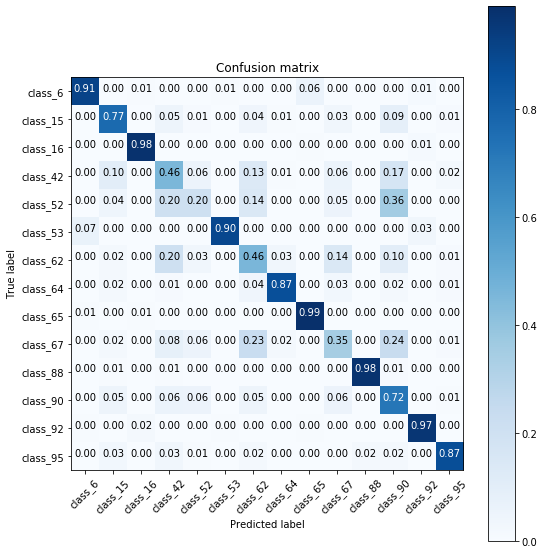

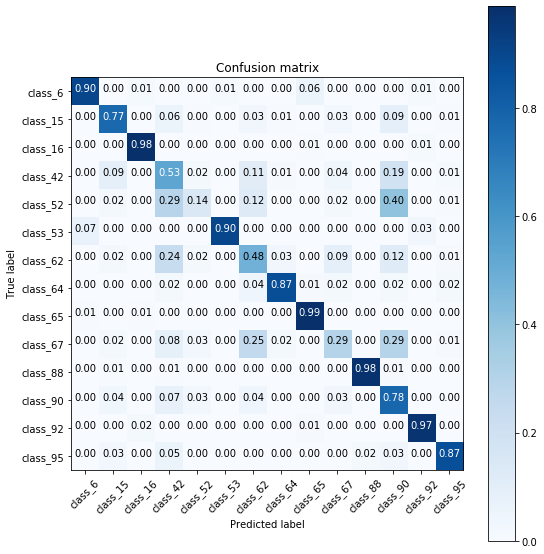

In [40]:
## =======================================================
## Validation
## =======================================================

print('LGB MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=lgb_oof_train))
print('XGB MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=xgb_oof_train))

# define function to plot confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


def model_confusion(y,model_preds):
    unique_y = np.unique(y)
    class_map = dict()
    for i,val in enumerate(unique_y):
        class_map[val] = i
    class_names = list(sample_sub.columns[1:-1])
    y_map = np.zeros((y.shape[0],))
    y_map = np.array([class_map[val] for val in y])
    cnf_matrix = confusion_matrix(y_map, np.argmax(model_preds,axis=-1))
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_map, np.argmax(model_preds,axis=-1),target_names=class_names))
    np.set_printoptions(precision=2)
    plt.figure(figsize=(8,8))
    plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')
    
model_confusion(y,lgb_oof_train)
model_confusion(y,xgb_oof_train)

In [0]:
## ============================================================
## Test Set Predictions
## 1st level using XGB and LGB model    
## ============================================================
def predict_chunk(df_, clfs_, meta_, features, train_mean):
    # Group by object id    
    full_test = featurize(df_,meta_)
    full_test = full_test.fillna(0)
    # Make predictions
    preds_ = None
    for clf in clfs_:
        if preds_ is None:
            preds_ = clf.predict_proba(full_test[features]) / len(clfs_)
        else:
            preds_ += clf.predict_proba(full_test[features]) / len(clfs_)
    # Compute preds_99 as the proba of class not being any of the others
    # preds_99 = 0.1 gives 1.769
    preds_99 = np.ones(preds_.shape[0])
    for i in range(preds_.shape[1]):
        preds_99 *= (1 - preds_[:, i])
    # Create DataFrame from predictions
    preds_df_ = pd.DataFrame(preds_, columns=['class_' + str(s) for s in clfs_[0].classes_])
    preds_df_['object_id'] = full_test['object_id']
    preds_df_['class_99'] = 0.14 * preds_99 / np.mean(preds_99) 
    return preds_df_ 
def test_pred(testfile,chunks,clfs):
    start = time.time()
    remain_df = None
    final_preds = pd.DataFrame()
    for i_c, df in enumerate(pd.read_csv(testfile, chunksize=chunks, iterator=True)): 
        # Check object_ids
        # I believe np.unique keeps the order of group_ids as they appear in the file
        unique_ids = np.unique(df['object_id'])
        new_remain_df = df.loc[df['object_id'] == unique_ids[-1]].copy()
        if remain_df is None:
            df = df.loc[df['object_id'].isin(unique_ids[:-1])]
        else:
            df = pd.concat([remain_df, df.loc[df['object_id'].isin(unique_ids[:-1])]], axis=0)
        # Create remaining samples df
        remain_df = new_remain_df
        preds_df = predict_chunk(df_=df,
                                 clfs_=clfs,
                                 meta_=test_meta,
                                 features=full_train.columns,
                                 train_mean=train_mean)
        final_preds = pd.concat([final_preds, preds_df], axis=0)
        del preds_df
        gc.collect()
        print('%15d done in %5.1f minutes' % (chunks * (i_c + 1), (time.time() - start) / 60), flush=True)
    # Compute last object in remain_df
    preds_df = predict_chunk(df_=remain_df,
                         clfs_=clfs,
                         meta_=test_meta,
                         features=full_train.columns,
                         train_mean=train_mean)
    final_preds = pd.concat([final_preds, preds_df], axis=0)
    return final_preds

In [0]:
# Create test set predictions using 1st level LGB/XGB models
lgb_oof_test = test_pred(testfile = 'test_set.csv',chunks = 5000000, clfs=light_clfs)
xgb_oof_test = test_pred(testfile = 'test_set.csv',chunks = 5000000, clfs=xg_clfs)


In [41]:
## ============================================================
## Stacking
## 2nd level using LGB classifier
## ============================================================
second_train = pd.concat((pd.DataFrame(xgb_oof_train), pd.DataFrame(lgb_oof_train)),axis=1)
#second_test = pd.concat((pd.DataFrame(xgb_oof_test), pd.DataFrame(lgb_oof_test)),axis=1)
# Fit LGBMClassifier as second level meta model
second_clfs, second_importances, second_oof_train =lgb_train_pred(second_train,y)[0], \
lgb_train_pred(second_train,y)[1], lgb_train_pred(second_train,y)[2]  
gc.collect()

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.618589	training's wloss: 0.600494	valid_1's multi_logloss: 0.926131	valid_1's wloss: 0.794559
[200]	training's multi_logloss: 0.46402	training's wloss: 0.446272	valid_1's multi_logloss: 0.812647	valid_1's wloss: 0.715283
Early stopping, best iteration is:
[221]	training's multi_logloss: 0.448207	training's wloss: 0.430511	valid_1's multi_logloss: 0.805428	valid_1's wloss: 0.714233
0.7142327385037598
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.620969	training's wloss: 0.602392	valid_1's multi_logloss: 0.908163	valid_1's wloss: 0.743365
[200]	training's multi_logloss: 0.461127	training's wloss: 0.44217	valid_1's multi_logloss: 0.797536	valid_1's wloss: 0.657121
Early stopping, best iteration is:
[219]	training's multi_logloss: 0.446534	training's wloss: 0.427575	valid_1's multi_logloss: 0.789852	valid_1's wloss: 0.653863
0.6538630073792088
Tr

29593

In [29]:
np.unique(y)

array([ 6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95])

SECOND LEVEL MULTI WEIGHTED LOG LOSS : 0.66467 
Classification Report:
              precision    recall  f1-score   support

     class_6       0.90      0.92      0.91       151
    class_15       0.57      0.76      0.65       495
    class_16       0.99      0.98      0.98       924
    class_42       0.70      0.38      0.49      1193
    class_52       0.09      0.29      0.14       183
    class_53       0.79      0.90      0.84        30
    class_62       0.41      0.48      0.44       484
    class_64       0.59      0.90      0.71       102
    class_65       0.99      0.98      0.99       981
    class_67       0.20      0.53      0.29       208
    class_88       0.98      0.98      0.98       370
    class_90       0.83      0.63      0.72      2313
    class_92       0.95      0.97      0.96       239
    class_95       0.72      0.90      0.80       175

    accuracy                           0.71      7848
   macro avg       0.69      0.76      0.71      7848
weighted 

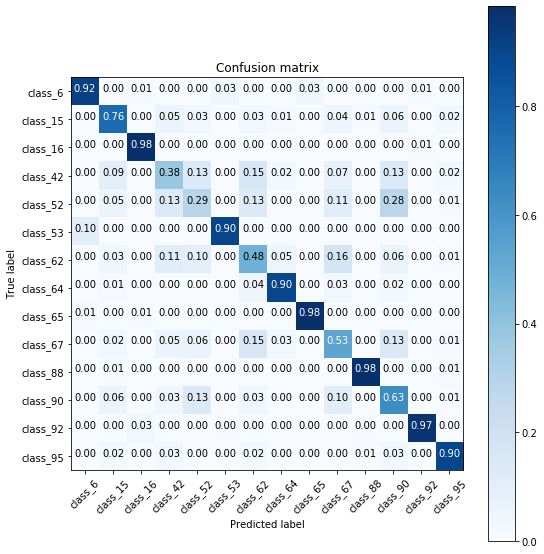

In [43]:
## ============================================================
## Evaluation
## Print classification report for final model
## ============================================================
print('SECOND LEVEL MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=second_oof_train))
model_confusion(y, second_oof_train)


In [0]:
###### RUN:
def main():
    full_train = featurize(train,train_meta)
    y = full_train['target']
    full_train =  full_train.drop(labels=['target','object_id','hostgal_specz','ra', 'decl', 'gal_l', 'gal_b','ddf'], axis=1)
    # Impute NAs with mean:
    train_mean = full_train.mean(axis=0)
    full_train.fillna(0, inplace=True)
    seed = 1
    folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 14,
        'metric': 'multi_logloss',
        'learning_rate': 0.03,
        'subsample': .9,
        'colsample_bytree': 0.5,
        'reg_alpha': .01,
        'reg_lambda': .01,
        'min_split_gain': 0.01,
        'min_child_weight': 10,
        'n_estimators': 1000,
        'silent': -1,
        'verbose': -1,
        'max_depth': 3,
        'n_jobs' : 4}
    xgb_params = {    
            'objective': 'multi:softprob', 
            'eval_metric': 'mlogloss', 
            'silent': True, 
            'num_class':14,    
            'booster': 'gbtree',
            'n_jobs': 4,
            'n_estimators': 1000,
            'tree_method': 'hist',
            'grow_policy': 'lossguide',
            'base_score': 0.25,
            'max_depth': 7,
            'max_delta_step': 2,  #default=0
            'learning_rate': 0.03,
            'max_leaves': 11,
            'min_child_weight': 64,
            'gamma': 0.1, # default=
            'subsample': 0.7,
            'colsample_bytree': 0.68,
            'reg_alpha': 0.01, # default=0
            'reg_lambda': 10., # default=1
            'seed': seed}
    light_clfs, light_importances, lgb_oof_train = lgb_train_pred(full_train,y)[0], \
        lgb_train_pred(full_train,y)[1], lgb_train_pred(full_train,y)[2]
    xg_clfs, xg_importances, xgb_oof_train = xgb_train_pred(full_train,y)[0], \
        xgb_train_pred(full_train,y)[1], xgb_train_pred(full_train,y)[2]    
    gc.collect()
    print('LGB MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=lgb_oof_train))
    print('XGB MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=xgb_oof_train))
    print('starting lgb tests')
    lgb_oof_test = test_pred(testfile = 'test_set.csv',chunks = 5000000, clfs=light_clfs)
    print('starting xgb tests')
    xgb_oof_test = test_pred(testfile = 'test_set.csv',chunks = 5000000, clfs=xg_clfs)
    ## ============================================================
    ## Stacking
    ## 2nd level using LGB classifier
    ## ============================================================
    second_train = pd.concat((pd.DataFrame(xgb_oof_train), pd.DataFrame(lgb_oof_train)),axis=1)
    second_test = pd.concat((pd.DataFrame(xgb_oof_test), pd.DataFrame(lgb_oof_test)),axis=1)
    # Fit LGBMClassifier as second level meta model
    second_clfs, second_importances, second_oof_train =lgb_train_pred(second_train,y)[0], \
        lgb_train_pred(second_train,y)[1], lgb_train_pred(second_train,y)[2]  
    gc.collect()
    ## ============================================================
    ## Evaluation
    ## Print classification report for final model
    ## ============================================================
    from sklearn.metrics import classification_report
    print(classification_report(y, second_oof_train))

    ## ============================================================
    ## Final submission 
    ## ============================================================
    print('starting final tests')
    final_preds = test_pred(testfile = 'test_set.csv', chunks = 5000000, clfs=second_clfs)
    final_preds.to_csv('submission.csv', header=False, mode='a', index=False)
    return [light_clfs,xg_clfs,second_clfs]

In [0]:
[light_clfs,xg_clfs,second_clfs] = main()